## Colab preamble

If this notebook is running on Google CoLab, we need to set up the required dependencies. The cell below checks if we're running on colab and tries to install the needed dependencies

In [1]:
# This installs the concacolab package in the colab python distribution
try:
    import google.colab
    # Install required packages.
    import os
    import torch
    os.environ['TORCH'] = torch.__version__
    print(torch.__version__)

    !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
    !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
    !pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
    !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
    pip install lightning
except:
    pass

# Building the neural network

We've now done the lions share of the work - converting the data we have into a graph dataset which can be fed into a neural network. We're now ready to implement our model. We will pose this problem as classification problem where the goal is to correctly classify the ISUP Grade.


### The dataset

We include the dataset code definition we built in the previous notebook. Note that by setting the variable `FULL_DATASET` to `True`, you can train the models on the full dataset. This will require a lot more memory and time though, so should be done on a more capable computer than the colab virtual machines.

In [2]:
from pathlib import Path
import zipfile
from io import StringIO, BytesIO
import multiprocessing
from collections import Counter
from typing import Sequence, Literal, Optional
import copy
import json

import torch
from torch_geometric.data import InMemoryDataset, download_url, Data
from torch_geometric.data.dataset import IndexType
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree


GEOJSON_DIRECTORY = 'cell_detection.geojson'
LABEL_COLUMN = 'isup_grade'
ID_COLUMN = 'image_id'
MPP = 0.48
RADIUS_MICRONS = 20
RADIUS = RADIUS_MICRONS / MPP

PANDA_FULL_URL = 'https://github.com/eryl/aida-gnn-workshop-code/releases/download/PANDa_workshop_data_full_v1/PANDa_{}.zip'
PANDA_SUBSET_URL = 'https://github.com/eryl/aida-gnn-workshop-code/releases/download/PANDa_workshop_data_v1/PANDa_{}.zip'

# You can switch to using the full 10615 files by setting this to True. 
# Warning! It will require a lot of memory to hold it in RAM. 
# The total download is about 1.5GB for the full set and 300MB for the subset.
FULL_DATASET = False
if FULL_DATASET:
    DATASET_URL = PANDA_FULL_URL
    DATASET_DIR = '../datasets/PANDa_full'
else:
    DATASET_URL = PANDA_SUBSET_URL
    DATASET_DIR = '../datasets/PANDa'


class PANDaGraphDataset(InMemoryDataset):
    data_url = DATASET_URL
    data_split = ''
    
    def __init__(self, root=DATASET_DIR, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)
        self.data, self.slices, self.label_map, self.node_type_map = torch.load(self.processed_paths[0])
    
    @property
    def raw_file_names(self):
        return [f'PANDa_{self.data_split}.zip']

    @property
    def processed_file_names(self):
        return [f'PANDa_{self.data_split}.pt']

    def download(self):
        # Download to `self.raw_dir`.
        url = self.data_url.format(self.data_split)
        download_url(url, self.raw_dir)

    def _transpose_geojson(self, geojson_obj):
        node_positions = []
        node_types = []
        for feature_obj in geojson_obj:
            if feature_obj.get('type') == 'Feature':
                feature_coordinates = feature_obj['geometry']['coordinates']
                node_positions.extend(feature_coordinates)
                feature_labels = [feature_obj['properties']['classification']['name']]*len(feature_coordinates)
                node_types.extend(feature_labels)
        return np.array(node_positions), node_types

    def _create_edges(self, node_positions, radius=RADIUS):
        spatial_index = cKDTree(node_positions)
        sparse_distances = spatial_index.sparse_distance_matrix(spatial_index, radius, output_type='coo_matrix')
        sparse_distances.eliminate_zeros()  # We eliminate all zeros from the matrix, we don't want self-loops
        pair_indices = np.stack([sparse_distances.row, sparse_distances.col], axis=0)
        distances = np.copy(sparse_distances.data)
        return pair_indices, distances

    def _convert_geojson_to_graph(self, geojson_string):
        geojson_object = json.loads(geojson_string)
        node_positions, node_classes = self._transpose_geojson(geojson_object)
        edges, distances = self._create_edges(node_positions)
        return {'edges': edges, 'edge_distance': distances, 'node_positions': node_positions, 'node_types': node_classes}

    def _read_geojson_archive(self):
        LABEL_COLUMN = 'isup_grade'
        ID_COLUMN = 'image_id'  
        graphs = dict()

        for filename in self.raw_file_names:
            file_path = Path(self.raw_dir) / filename
            with zipfile.ZipFile(file_path) as zf:
                graphs = dict()
                csv_file = None
                for name in tqdm(zf.namelist(), desc="Creating graph data"):
                    if GEOJSON_DIRECTORY in name:
                        *_, image_id = name.split('/')
                        geojson_string = zf.read(name)
                        graph_data = self._convert_geojson_to_graph(geojson_string)
                        graph_data['image_id'] = image_id
                        graphs[image_id] = graph_data
                    elif '.csv' in name:
                        csv_string = zf.read(name)
                        csv_io = BytesIO(csv_string)
                        csv_file = pd.read_csv(csv_io)
                        
                if csv_file is None:
                    raise RuntimeError("No csv file in archive")
                else:
                    for row in csv_file.to_dict('records'):
                        image_id = row[ID_COLUMN]
                        if image_id in graphs:
                            label = row[LABEL_COLUMN]
                            graphs[image_id]['label'] = label 
        return graphs
    
    def _convert_labels_inplace(self, graphs):
        labels = set()
        for graph in graphs.values():
            labels.add(graph['label'])
        label_map = {node_type: i for i,node_type in enumerate(sorted(labels))}
        for graph in graphs.values():
            label = graph['label']
            encoded_label = torch.tensor(label_map[label])
            graph['label'] = encoded_label
        return label_map

    def _convert_node_types_inplace(self, graphs):
        node_types = set()
        for graph in graphs.values():
            node_types.update(graph['node_types'])
        node_type_map = {node_type: i for i,node_type in enumerate(sorted(node_types))}
        for graph in graphs.values():
            node_types = graph['node_types']
            node_types = torch.tensor([node_type_map[node_type] for node_type in node_types])
            graph['node_types'] = node_types
        return node_type_map

    def _convert_to_pyg_data(self, graph):
        x=graph['node_types']
        edge_index=torch.tensor(graph['edges'])
        edge_attr=torch.tensor(graph['edge_distance'])
        y=graph['label']
        pos=torch.tensor(graph['node_positions'])
        return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y, pos=pos)

    def process(self):
        # Read data huge `Data` list.
        graphs = self._read_geojson_archive()
        label_map = self._convert_labels_inplace(graphs)
        node_type_map = self._convert_node_types_inplace(graphs)

        data_list = [self._convert_to_pyg_data(graph) for graph in tqdm(graphs.values(), desc="Converting graphs")]

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        data, slices = self.collate(data_list)
        torch.save((data, slices, label_map, node_type_map), self.processed_paths[0])

    
class PANDaGraphDatasetTrain(PANDaGraphDataset):
    data_split = 'train'

class PANDaGraphDatasetDev(PANDaGraphDataset):
    data_split = 'dev'

class PANDaGraphDatasetTest(PANDaGraphDataset):
    data_split = 'test'



In [3]:
train_dataset = PANDaGraphDatasetTrain()
test_dataset = PANDaGraphDatasetTest()
dev_dataset = PANDaGraphDatasetDev()

In [4]:
train_dataset

PANDaGraphDatasetTrain(1596)

### DataLoaders

Pytorch Geometric has its own dataloaders. It allows for efficient batching of graphs by using the fact that all of the PyG operations rely on sparse implementations. By taking all graphs and essentially putting them into on large batch graph, the algorithms dont have to keep special track of batch examples as long as the operations are restricted to follow the graph structure.

In [5]:
from torch_geometric.loader import DataLoader
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, drop_last=False, shuffle=True, num_workers=4)
dev_dataloader = DataLoader(dev_dataset, batch_size=batch_size, drop_last=False, shuffle=False, num_workers=4)


## Predefined models

We can build a GNN using the pre-existing [models](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#models) in Pytorch Geometric. These implements a handful of successful models from the litterature. We will look use the updated Graph Attention Networks from [“How Attentive are Graph Attention Networks?”](https://arxiv.org/abs/2105.14491).
Below is a the signature of the constructur and an explanation of the arguments:

```python
class GAT(in_channels: int, hidden_channels: int, num_layers: int, out_channels: Optional[int] = None, dropout: float = 0.0, act: Optional[Union[str, Callable]] = 'relu', act_first: bool = False, act_kwargs: Optional[Dict[str, Any]] = None, norm: Optional[Union[str, Callable]] = None, norm_kwargs: Optional[Dict[str, Any]] = None, jk: Optional[str] = None, **kwargs)
```

 - **in_channels** (int or tuple) – Size of each input sample, or -1 to derive the size from the first input(s) to the forward method. A tuple corresponds to the sizes of source and target dimensionalities.
 - **hidden_channels** (int) – Size of each hidden sample.
 - **num_layers** (int) – Number of message passing layers.
 - **out_channels** (int, optional) – If not set to None, will apply a final linear transformation to convert hidden node embeddings to output size out_channels. (default: None)
 - **v2** (bool, optional) – If set to True, will make use of GATv2Conv rather than GATConv. (default: False)
 - **dropout** (float, optional) – Dropout probability. (default: 0.)
 - **act** (str or Callable, optional) – The non-linear activation function to use. (default: "relu")
 - **act_first** (bool, optional) – If set to True, activation is applied before normalization. (default: False)
 - **act_kwargs** (Dict[str, Any], optional) – Arguments passed to the respective activation function defined by act. (default: None)
 - **norm** (str or Callable, optional) – The normalization function to use. (default: None)
 - **norm_kwargs** (Dict[str, Any], optional) – Arguments passed to the respective normalization function defined by norm. (default: None)
 - **jk** (str, optional) – The Jumping Knowledge mode. If specified, the model will additionally apply a final linear transformation to transform node embeddings to the expected output feature dimensionality. (None, "last", "cat", "max", "lstm"). (default: None)
 - ****kwargs** (optional) – Additional arguments of conv.GATConv or conv.GATv2Conv.

We will create a separate configuration class which encapsulates the important arguments of this class. Many of arguments are shared between different prebuilt models, and you can experiment with replacing the GAT class with some other (e.g. GIN or GCN).

In [6]:
from dataclasses import dataclass
from typing import Type

import torch
#import lightning.pytorch as pl
from torch_geometric.nn import global_mean_pool


@dataclass
class PANDaGATConfig:
    d_model: int
    n_layers: int
    dropout_rate: float


class LightningPANDaGAT(torch.nn.Module):
    def __init__(self, node_type_map, num_classes, config: PANDaGATConfig):
        super().__init__()
        self.node_type_map = node_type_map
        self.config = config
        self.num_classes = num_classes
        
        self.node_type_embedding = torch.nn.Embedding(len(node_type_map), config.d_model)
        self.gnn_encoder = torch_geometric.nn.GCN(in_channels=config.d_model, 
                                                  hidden_channels=config.d_model, 
                                                  num_layers=config.n_layers, 
                                                  dropout=config.dropout_rate, 
                                                  norm=None, # Adding a layer norm might be useful
                                                  norm_kwargs=None)
        self.output_head = torch.nn.Sequential(torch.nn.Linear(config.d_model, config.d_model), 
                                               torch.nn.ReLU(), 
                                               torch.nn.Dropout(config.dropout_rate), 
                                               torch.nn.Linear(config.d_model, num_classes))

    def forward(self, batch):
        # X contains our node attributes. In our case it's the classes assigned to each node. We need to embed them first:
        x = self.node_type_embedding(batch.x)
        x = self.gnn_encoder(x=x, edge_index=batch.edge_index)
        x = global_mean_pool(x, batch.batch)
        
        predictions = self.output_head(x)

        return predictions

    def loss_on_batch(self, batch):
        target = batch.y

        predictions = self(batch)
        loss = torch.nn.functional.cross_entropy(predictions, target)

        return loss
    
    def loss_and_acc_on_batch(self, batch):
        target = batch.y

        predictions = self(batch)
        loss = torch.nn.functional.cross_entropy(predictions, target)

        correct_predictions = predictions.detach().argmax(dim=-1) == target
        accuracy = torch.mean(correct_predictions.to(dtype=torch.float)).item()

        return loss, accuracy
    
    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        training_loss = self.loss_on_batch(batch)
        return training_loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=1e-3)
        return optimizer

    def test_step(self, batch, batch_idx):
        # this is the test loop
        test_loss = self.loss_on_batch(batch).item()
        #self.log("test_loss", test_loss)
        return test_loss

    def validation_step(self, batch, batch_idx):
        # this is the dev/validation loop
        val_loss, accuracy = self.loss_and_acc_on_batch(batch)
        #self.log("val_loss", val_loss.item())
        #self.log("val_accuracy", accuracy)
        return val_loss

    def predict_step(self, batch, batch_idx):
        targets = batch.y
        predictions = self(batch)

        return (predictions.detach().argmax(dim=-1), targets)
        



In [7]:
import torch_geometric

d_model = 32

gnn_config = PANDaGATConfig(
    d_model=d_model,
    n_layers=4,
    dropout_rate=0.1,
)
num_classes = train_dataset.num_classes

model = LightningPANDaGAT(train_dataset.node_type_map, num_classes, gnn_config)

device = torch.device('cuda')
model.to(device)

LightningPANDaGAT(
  (node_type_embedding): Embedding(5, 32)
  (gnn_encoder): GCN(32, 32, num_layers=4)
  (output_head): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=32, out_features=6, bias=True)
  )
)

In [8]:
from tqdm.notebook import tqdm, trange
max_epochs = 10
optimizer = model.configure_optimizers()

epoch_pbar = tqdm(total=max_epochs, desc='Epoch', leave=True)
train_pbar = tqdm(total=len(train_dataloader), desc='Training batch', leave=True)
dev_pbar = tqdm(total=len(dev_dataloader), desc='Dev batch', leave=True)
for epoch in range(max_epochs):
    for i,batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        loss = model.training_step(batch.to(device), i)

        loss.backward()
        optimizer.step()
        train_pbar.update()
    validation_losses = []
    for i,batch in enumerate(dev_dataloader):
        with torch.no_grad():
            loss = model.validation_step(batch.to(device), i)
            validation_losses.append(loss.item())
        dev_pbar.update()

    validation_loss = np.mean(validation_losses)
    epoch_pbar.set_description(f"Epoch (previous dev loss:{validation_loss})")
    epoch_pbar.update()
    train_pbar.reset()
    dev_pbar.reset()

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training batch:   0%|          | 0/50 [00:00<?, ?it/s]

Dev batch:   0%|          | 0/7 [00:00<?, ?it/s]

In [9]:
test_dataloader = DataLoader(test_dataset, batch_size=32, drop_last=False, shuffle=False, num_workers=4)
predictions = []
targets = []
for i, test_batch in enumerate(tqdm(test_dataloader, desc="Test batch")):
    batch_predictions, batch_targets = model.predict_step(test_batch.to(device), i)
    predictions.append(batch_predictions.cpu().numpy())
    targets.append(batch_targets.cpu().numpy())
predictions = np.concatenate(predictions)
targets = np.concatenate(targets)

Test batch:   0%|          | 0/7 [00:00<?, ?it/s]

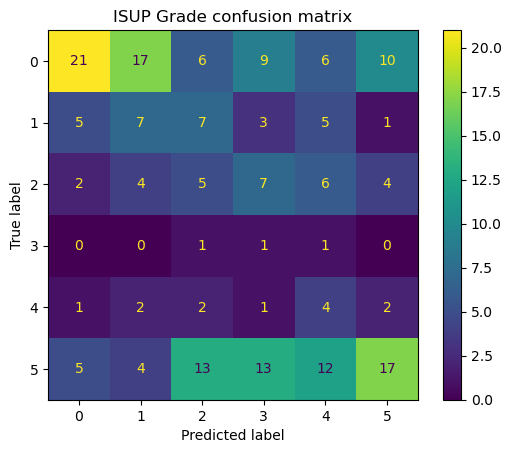

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
major_confusion = confusion_matrix(predictions, targets)
ConfusionMatrixDisplay(major_confusion).plot()
plt.title("ISUP Grade confusion matrix")
plt.show()

## Finer control with GConvLayers

The implemented models in Pytorch Geometric covers some basic cases, but we might often wan't to tweak the architecture of the network. We will now look at how we can implement our own Graph Neural Networks by using the different Graph Convolution Layers of Pytorch Geometric.

### Pytorch Lightning

We will be using [Pytorch Lightning](https://github.com/Lightning-AI/lightning) to simplify boiler plate code for training. It gives us many features without us having to implement them such as checkpointing, logging, early stopping, learning rate scheduling etc. Unfortunately, the current version doesn't work well with the predefined Pytorch Geometric models, which is the reason why we didn't use them in the example above. The issue seems to be that Pytorch Lightning tries to use the Pytorch JIT decorated functions of the BaseGNN which makes memory consumption blow up.

In [26]:
from dataclasses import dataclass
from typing import Type

import torch
import lightning.pytorch as pl
from torch_geometric.nn import global_mean_pool, global_max_pool

@dataclass
class LayerConfig:
    layer_dim: int    
    conv_module: Type
    nonlinearity: Type
    dropout_rate: float

@dataclass
class PANDaGNNConfig:
    d_model: int
    output_head_ffn_dim: int
    n_gnn_layers: int
    dropout_rate: float
    gnn_layer_type: Type
    gnn_layer_config: LayerConfig
    residual_connections: bool = True
    

class GNNLayer(torch.nn.Module):
    "Implements a GNN block, including nonlinearity and normalizations"
    def __init__(self, input_dim, config: LayerConfig):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = config.layer_dim
        self.config = config
        self.conv_layer = config.conv_module(self.input_dim, self.output_dim)
        self.nonlinearity = config.nonlinearity()
        self.dropout = torch.nn.Dropout(config.dropout_rate)
        
    def forward(self, x, batch):
        x = self.conv_layer(x, batch.edge_index)
        x = self.nonlinearity(x)
        x = self.dropout(x)
        return x


class LightningPANDaGNN(pl.LightningModule):
    def __init__(self, node_type_map, num_classes, config: PANDaGNNConfig):
        super().__init__()
        self.node_type_map = node_type_map
        self.config = config
        self.num_classes = num_classes
        
        self.node_type_embedding = torch.nn.Embedding(len(node_type_map), config.d_model)
        dim_from_below = config.d_model
        self.gnn_layers = torch.nn.ModuleList()

        for i in range(config.n_gnn_layers):
            layer = self.config.gnn_layer_type(dim_from_below, self.config.gnn_layer_config)
            dim_from_below = layer.output_dim
            self.gnn_layers.append(layer)

        self.output_head = torch.nn.Sequential(torch.nn.Linear(dim_from_below, config.output_head_ffn_dim), torch.nn.ReLU(), torch.nn.Dropout(config.dropout_rate), torch.nn.Linear(config.output_head_ffn_dim, num_classes))

    def forward(self, batch):
        # X contains our node attributes. In our case it's the classes assigned to each node. We need to embed them first:
        x = self.node_type_embedding(batch.x)
        for gnn_layer in self.gnn_layers:
            if self.config.residual_connections:
                x = x + gnn_layer(x, batch)
            else:
                x = gnn_layer(x, batch)

        x = global_mean_pool(x, batch.batch)
        
        predictions = self.output_head(x)

        return predictions

    def loss_on_batch(self, batch):
        target = batch.y

        predictions = self(batch)
        loss = torch.nn.functional.cross_entropy(predictions, target)

        return loss
    
    def loss_and_acc_on_batch(self, batch):
        target = batch.y

        predictions = self(batch)
        loss = torch.nn.functional.cross_entropy(predictions, target)

        correct_predictions = predictions.detach().argmax(dim=-1) == target
        accuracy = torch.mean(correct_predictions.to(dtype=torch.float)).item()

        return loss, accuracy
    
    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        self.train()
        training_loss = self.loss_on_batch(batch)
        self.log("train_loss", training_loss.item())
        return training_loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=3e-4)
        return optimizer

    def test_step(self, batch, batch_idx):
        # this is the test loop
        self.eval()
        test_loss = self.loss_on_batch(batch)
        self.log("test_loss", test_loss)

    def validation_step(self, batch, batch_idx):
        # this is the dev/validation loop
        self.eval()
        val_loss, accuracy = self.loss_and_acc_on_batch(batch)
        self.log("val_loss", val_loss)
        self.log("val_accuracy", accuracy)

    def predict_step(self, batch, batch_idx):
        self.eval()
        targets = batch.y
        predictions = self(batch)

        return (predictions.detach().argmax(dim=-1), targets)
        



In [27]:
import torch_geometric

d_model = 32

layer_config = LayerConfig(layer_dim=d_model, 
                           conv_module=torch_geometric.nn.GCNConv, 
                          nonlinearity=torch.nn.ReLU, 
                          dropout_rate=0.1)
gnn_config = PANDaGNNConfig(
    d_model=d_model,
    output_head_ffn_dim=d_model,
    n_gnn_layers=4,
    dropout_rate=0.1,
    gnn_layer_type=GNNLayer,
    gnn_layer_config=layer_config,
    residual_connections=True
)
num_classes = train_dataset.num_classes

model = LightningPANDaGNN(train_dataset.node_type_map, num_classes, gnn_config)

In [28]:
from pathlib import Path
import sys

from lightning import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.lr_monitor import LearningRateMonitor
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

CHECKPOINT_PATH = Path('../models')


trainer = Trainer(
        default_root_dir = CHECKPOINT_PATH,  # Where to save models
        # We run on a single GPU (if possible)
        accelerator="auto",
        devices=1,
        precision=16,
        # How many epochs to train for if no patience is set
        max_epochs=10,
        callbacks=[
            ModelCheckpoint(
                save_weights_only=True, mode="min", monitor="val_loss"
            ),  # Save the best checkpoint based on the maximum val_acc recorded. Saves only weights and not optimizer
            LearningRateMonitor("epoch"),
        ],  # Log learning rate every epoch
    )  # In case your notebook crashes due to the progress bar, consider increasing the refresh rate


/home/erik/mambaforge/envs/aida_workshop_gnn/lib/python3.9/site-packages/lightning/fabric/connector.py:554: UserWarning: 16 is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
  rank_zero_warn(
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [29]:
from torch_geometric.loader import DataLoader
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, drop_last=False, shuffle=True, num_workers=4)
dev_dataloader = DataLoader(dev_dataset, batch_size=batch_size, drop_last=False, shuffle=False, num_workers=4)


In [30]:
%reload_ext tensorboard
%tensorboard --logdir=../models/lightning_logs/

Reusing TensorBoard on port 6006 (pid 27641), started 0:02:28 ago. (Use '!kill 27641' to kill it.)

In [31]:
trainer.fit(model, train_dataloader, dev_dataloader)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type       | Params
---------------------------------------------------
0 | node_type_embedding | Embedding  | 160   
1 | gnn_layers          | ModuleList | 4.2 K 
2 | output_head         | Sequential | 1.3 K 
---------------------------------------------------
5.6 K     Trainable params
0         Non-trainable params
5.6 K     Total params
0.023     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [32]:
test_dataloader = DataLoader(test_dataset, batch_size=32, drop_last=False, shuffle=False, num_workers=4)
predictions = trainer.predict(dataloaders=test_dataloader)
predictions, targets = zip(*predictions)
predictions = torch.cat(predictions)
targets = torch.cat(targets)

/home/erik/mambaforge/envs/aida_workshop_gnn/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: UserWarning: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
Restoring states from the checkpoint path at ../models/lightning_logs/version_17/checkpoints/epoch=6-step=350.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ../models/lightning_logs/version_17/checkpoints/epoch=6-step=350.ckpt


Predicting: 0it [00:00, ?it/s]

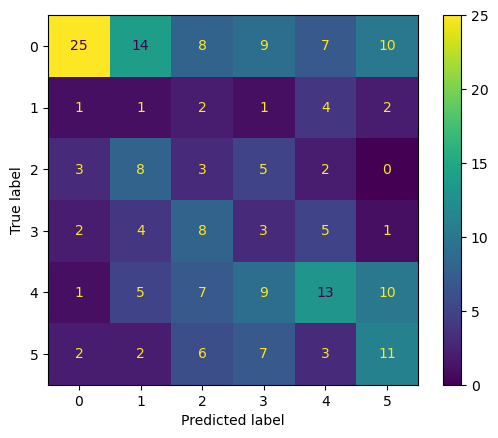

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
major_confusion = confusion_matrix(predictions, targets)
ConfusionMatrixDisplay(major_confusion).plot()
plt.show()

## Changing Conv layer

Here we will look at how we can change the convolution layer we use and whether that will have some effect. A list of available layers can be found at the PyG [documentation](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#convolutional-layers).

In [ ]:
import torch_geometric

d_model = 128

layer_config = LayerConfig(layer_dim=d_model, 
                           conv_module=torch_geometric.nn.GATv2Conv, 
                           nonlinearity=torch.nn.ReLU, 
                           dropout_rate=0.5)
gnn_config = PANDaGNNConfig(
    d_model=d_model,
    output_head_ffn_dim=d_model,
    n_gnn_layers=6,
    dropout_rate=0.5,
    gnn_layer_type=GNNLayer,
    gnn_layer_config=layer_config,
    residual_connections=True
)
num_classes = train_dataset.num_classes

model = LightningPANDaGNN(train_dataset.node_type_map, num_classes, gnn_config)

In [ ]:
from pathlib import Path
import sys

from lightning import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.lr_monitor import LearningRateMonitor
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

CHECKPOINT_PATH = Path('../models')


trainer = Trainer(
        default_root_dir = CHECKPOINT_PATH,  # Where to save models
        # We run on a single GPU (if possible)
        accelerator="auto",
        devices=1,
        precision=16,
        # How many epochs to train for if no patience is set
        max_epochs=1000,
        #enable_progress_bar=False,
        callbacks=[
            ModelCheckpoint(
                save_weights_only=True, mode="min", monitor="val_loss"
            ),  # Save the best checkpoint based on the maximum val_acc recorded. Saves only weights and not optimizer
            LearningRateMonitor("epoch"),
        ],  # Log learning rate every epoch
    )  # In case your notebook crashes due to the progress bar, consider increasing the refresh rate


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
from torch_geometric.loader import DataLoader
batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, drop_last=False, shuffle=True, num_workers=6)
dev_dataloader = DataLoader(dev_dataset, batch_size=batch_size, drop_last=False, shuffle=False, num_workers=4)

In [ ]:
trainer.fit(model, train_dataloader, dev_dataloader)



In [ ]:
%reload_ext tensorboard
%tensorboard --logdir=../models/lightning_logs/

Reusing TensorBoard on port 6006 (pid 15133), started 0:24:22 ago. (Use '!kill 15133' to kill it.)

In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size=32, drop_last=False, shuffle=False, num_workers=4)
predictions = trainer.predict(dataloaders=test_dataloader)
predictions, targets = zip(*predictions)
predictions = torch.cat(predictions)
targets = torch.cat(targets)

/home/erik/mambaforge/envs/aida_workshop_gnn/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: UserWarning: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
Restoring states from the checkpoint path at ../models/lightning_logs/version_15/checkpoints/epoch=73-step=14801.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ../models/lightning_logs/version_15/checkpoints/epoch=73-step=14801.ckpt


Predicting: 0it [00:00, ?it/s]

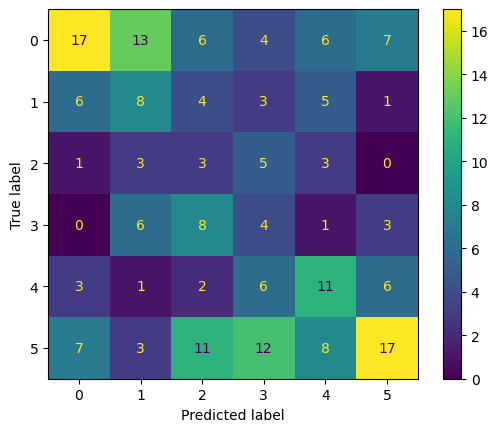

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
major_confusion = confusion_matrix(predictions, targets)
ConfusionMatrixDisplay(major_confusion).plot()
plt.show()

## Dropping the graph

Recall that we started out with a set of coordinates for detected cells in images. This wasn't really a graph, but by taking the distances between all nodes and applying a threshold we induced a graph. We can think of this as _computing_ an adjacency matrix based on some information about the elements of the node set (in this case their positions). We created an adjacency matrix looking something like this:
$$
\begin{bmatrix}
f(v_1, v_1) & \dots & f(v_1, v_n)\\
\vdots & \ddots & \vdots \\
f(v_n, v_1) & \dots & f(v_n, v_n)
\end{bmatrix}
$$

$$
\begin{align*}
f(u,v) &= \begin{cases}
    1, & \text{if } 0 \lt d(u,v) \lt r\\
    0, &\text{otherwise}
\end{cases}\\
d(u,v) &= \lVert u - v \rVert
\end{align*}
$$

Where $r$ was the radius we decided on.

Instead of thinking of this as a pre-processing step, we can think of it as part of our model, where we recompute the attention matrix after each message propagation. One neural network which implements this idea is the Dynamic Edge Convolution network, which instead of taking a graph of inputs takes a point cloud. Since our dataset already have the positions of all nodes, we don't have to do anything to it, only define a new model.

**N.B. the dynamic edge convolution seems to be broken in this implementation, this is left as an illustration**

In [ ]:
from dataclasses import dataclass
from typing import Type

import torch
import lightning.pytorch as pl
from torch_geometric.nn import global_mean_pool

@dataclass
class EdgeConvConfig:
    d_model: int
    ffn_dim: int
    dropout_rate: float
    k: int = 5

@dataclass
class PANDaPointNNConfig:
    d_model: int
    output_head_ffn_dim: int
    n_gnn_layers: int
    dropout_rate: float
    gnn_layer_type: Type
    gnn_layer_config: EdgeConvConfig
    residual_connections: bool = True
    

class EdgeConvNNLayer(torch.nn.Module):
    "Implements a Point NN block, including nonlinearity and normalizations"
    def __init__(self, input_dim, config: EdgeConvConfig):
        super().__init__()
        self.input_dim = config.d_model
        self.output_dim = config.d_model
        self.config = config
        edge_conv_nn = torch.nn.Sequential(torch.nn.Linear(input_dim, config.ffn_dim), 
                                           torch.nn.ReLU(), 
                                           torch.nn.Dropout(config.dropout_rate), 
                                           torch.nn.Linear(config.ffn_dim, self.output_dim))
        self.conv_layer = torch_geometric.nn.DynamicEdgeConv(nn=edge_conv_nn, k=config.k)
        self.nonlinearity = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(config.dropout_rate)
        
    def forward(self, x, batch):
        x = self.conv_layer(x, batch.batch)
        x = self.nonlinearity(x)
        x = self.dropout(x)
        return x


class LightningPANDaPointNN(pl.LightningModule):
    def __init__(self, node_type_map, node_feature_dim, num_classes, config: PANDaPointNNConfig):
        super().__init__()
        self.node_type_map = node_type_map
        self.node_feature_dim = node_feature_dim
        self.config = config
        self.num_classes = num_classes

        # We will concatenate the node embeddings with the node positions. We wish to end up with an
        # node feature size of d_model, so we need to set the embedding size to d_model - node_feature_dim
        self.embedding_dim = config.d_model - node_feature_dim
        self.num_embeddings = len(self.node_type_map)
        self.node_type_embedding = torch.nn.Embedding(self.num_embeddings, self.embedding_dim)
        
        dim_from_below = config.d_model
        self.gnn_layers = torch.nn.ModuleList()

        for i in range(config.n_gnn_layers):
            layer = self.config.gnn_layer_type(dim_from_below, self.config.gnn_layer_config)
            dim_from_below = layer.output_dim
            self.gnn_layers.append(layer)

        self.output_head = torch.nn.Sequential(torch.nn.Linear(dim_from_below, config.output_head_ffn_dim), torch.nn.ReLU(), torch.nn.Dropout(config.dropout_rate), torch.nn.Linear(config.output_head_ffn_dim, num_classes))

    def forward(self, batch):
        # X contains our node attributes. In our case it's the classes assigned to each node. 
        # We need to embed them first:
        x = self.node_type_embedding(batch.x)
        # batch.pos are our positional features. We simply concatenate them to the 
        # node embeddings along the feature dimension
        x = torch.cat([x, batch.pos], dim=-1)
        for gnn_layer in self.gnn_layers:
            if self.config.residual_connections:
                x = x + gnn_layer(x, batch)
            else:
                x = gnn_layer(x, batch)

        x = global_mean_pool(x, batch.batch)
        
        predictions = self.output_head(x)

        return predictions

    def loss_on_batch(self, batch):
        target = batch.y

        predictions = self(batch)
        loss = torch.nn.functional.cross_entropy(predictions, target)

        return loss
    
    def loss_and_acc_on_batch(self, batch):
        target = batch.y

        predictions = self(batch)
        loss = torch.nn.functional.cross_entropy(predictions, target)

        correct_predictions = predictions.detach().argmax(dim=-1) == target
        accuracy = torch.mean(correct_predictions.to(dtype=torch.float)).item()

        return loss, accuracy
    
    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        training_loss = self.loss_on_batch(batch)
        return training_loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=1e-3)
        return optimizer

    def test_step(self, batch, batch_idx):
        # this is the test loop
        test_loss = self.loss_on_batch(batch)
        self.log("test_loss", test_loss)

    def validation_step(self, batch, batch_idx):
        # this is the dev/validation loop
        val_loss, accuracy = self.loss_and_acc_on_batch(batch)
        self.log("val_loss", val_loss)
        self.log("val_accuracy", accuracy)

    def predict_step(self, batch, batch_idx):
        targets = batch.y
        predictions = self(batch)

        return (predictions.detach().argmax(dim=-1), targets)
        



In [ ]:
import torch_geometric

d_model = 128


layer_config = EdgeConvConfig(d_model=d_model, ffn_dim=d_model, dropout_rate=0.1)
                             
gnn_config = PANDaPointNNConfig(
    d_model=d_model,
    output_head_ffn_dim=d_model,
    n_gnn_layers=4,
    dropout_rate=0.1,
    gnn_layer_type=EdgeConvNNLayer,
    gnn_layer_config=layer_config,
    residual_connections=True
)
num_classes = train_dataset.num_classes
node_position_dimension = train_dataset[0].pos.shape[1] # We take the position array shape for the first element in our dataset
model = LightningPANDaPointNN(train_dataset.node_type_map, node_position_dimension, num_classes, gnn_config)

In [ ]:
from pathlib import Path

from lightning import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.lr_monitor import LearningRateMonitor
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

CHECKPOINT_PATH = Path('../models')

trainer = Trainer(
        default_root_dir = CHECKPOINT_PATH,  # Where to save models
        # We run on a single GPU (if possible)
        accelerator="auto",
        devices=1,
        precision=16,
        # How many epochs to train for if no patience is set
        max_epochs=10,
        callbacks=[
            ModelCheckpoint(
                save_weights_only=True, mode="min", monitor="val_loss"
            ),  # Save the best checkpoint based on the maximum val_acc recorded. Saves only weights and not optimizer
            LearningRateMonitor("epoch"),
        ],  # Log learning rate every epoch
    )  # In case your notebook crashes due to the progress bar, consider increasing the refresh rate
trainer.logger._log_graph = True  # If True, we plot the computation graph in tensorboard
trainer.logger._default_hp_metric = None  # Optional logging argument that we don't need

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
from torch_geometric.loader import DataLoader
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, drop_last=False, shuffle=True, num_workers=4)
dev_dataloader = DataLoader(dev_dataset, batch_size=batch_size, drop_last=False, shuffle=False, num_workers=4)
trainer.fit(model, train_dataloader, dev_dataloader)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type       | Params
---------------------------------------------------
0 | node_type_embedding | Embedding  | 630   
1 | gnn_layers          | ModuleList | 132 K 
2 | output_head         | Sequential | 17.3 K
---------------------------------------------------
150 K     Trainable params
0         Non-trainable params
150 K     Total params
0.600     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size=32, drop_last=False, shuffle=False, num_workers=4)
predictions = trainer.predict(dataloaders=test_dataloader)

Restoring states from the checkpoint path at ../models/gnn_model.pt/lightning_logs/version_23/checkpoints/epoch=9-step=720.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ../models/gnn_model.pt/lightning_logs/version_23/checkpoints/epoch=9-step=720.ckpt


Predicting: 0it [00:00, ?it/s]

In [ ]:
predictions, targets = zip(*predictions)
predictions = torch.cat(predictions)
targets = torch.cat(targets)

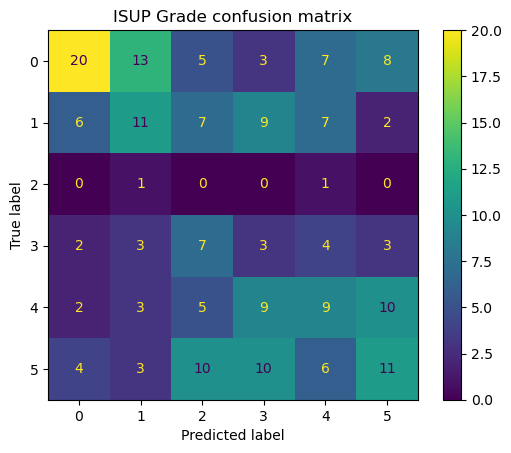

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
major_confusion = confusion_matrix(predictions, targets)
ConfusionMatrixDisplay(major_confusion).plot()
plt.title("ISUP Grade confusion matrix")
plt.show()